## 3.12　处理时间序列
由于Pandas最初是为金融模型而创建的，因此它拥有一些功能非常强大的日期、时间、带时间索引数据的处理工具。本节将介绍的日期与时间数据主要包含三类。
* **时间戳**表示**某个具体的时间点**（例如2015 年7 月4 日上午7 点）。
* **时间间隔与周期**表示**开始时间点与结束时间点之间的时间长度**，例如2015 年（指的是2015 年1 月1 日至2015 年12 月31 日这段时间间隔）。
<br>**周期通常是指一种特殊形式的时间间隔，每个间隔长度相同，彼此之间不会重叠**（例如，以24 小时为周期构成每一天）。
* **时间增量（time delta）或持续时间（duration）**表示**精确的时间长度**（例如，某程序运行持续时间22.56 秒）。

在本节内容中，我们将介绍Pandas中的3种日期/时间数据类型的具体用法。由于篇幅有限，后文无法对Python或Pandas的时间序列工具进行详细的介绍，仅仅是通过一个宽泛的综述，总结何时应该使用它们。
<br>在开始介绍Pandas 的时间序列工具之前，我们先简单介绍一下Python处理日期与时间数据的工具。在介绍完一些值得深入学习的资源之后，再通过一些简短的示例来演示Pandas处理时间序列数据的方法。

### 3.12.1　Python的日期与时间工具
在Python 标准库与第三方库中有许多可以表示日期、时间、时间增量和时间跨度（timespan）的工具。尽管Pandas 提供的时间序列工具更适合用来处理数据科学问题，但是了解Pandas 与Python 标准库以及第三方库中的其他时间序列工具之间的关联性将大有裨益。

#### 3.12.1.1. 原生Python的日期与时间工具：datetime与dateutil
Python 基本的日期与时间功能都在标准库的datetime 模块中。如果和第三方库dateutil模块搭配使用，可以快速实现许多处理日期与时间的功能。
<br>例如，你可以用datetime 类型创建一个日期：

In [1]:
from datetime import datetime

datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

或者使用dateutil 模块对各种字符串格式的日期进行正确解析：

In [2]:
from dateutil import parser

date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

一旦有了datetime 对象，就可以进行许多操作了，例如打印出这一天是星期几：

In [3]:
date.strftime('%A')

'Saturday'

在最后一行代码中，为了打印出是星期几，我们使用了一个标准字符串格式（standard string format）代码"%A"，你可以在Python 的[datetime 文档](https://docs.python.org/3/library/datetime.html) 的["strftime"节](https://docs.python.org/3/library/datetime.html#strftime-andstrptime-behavior )查看具体信息。关于dateutil 的其他日期功能可以通过[dateutil 的在线文档](http://labix.org/python-dateutil )学习。还有一个值得关注的程序包是[pytz](http://pytz.sourceforge.net/ )，这个工具解决了绝大多数时间序列数据都会遇到的难题：时区。

datetime 和dateutil 模块在灵活性与易用性方面都表现出色，你可以用这些对象及其相应的方法轻松完成你感兴趣的任意操作。**但如果你处理的时间数据量比较大，那么速度就会比较慢。**就像之前介绍过的Python 的原生列表对象没有NumPy 中已经被编码的数值类型数组的性能好一样，Python 的原生日期对象同样也没有NumPy 中已经被编码的日期（encoded dates）类型数组的性能好。

#### 3.12.1.2 时间类型数组：NumPy的datetime64类型
Python 原生日期格式的性能弱点促使NumPy 团队为NumPy 增加了自己的时间序列类型。
<br>datetime64 类型将日期编码为64 位整数，这样可以让日期数组非常紧凑（节省内存）。
<br>datetime64 需要在设置日期时**确定具体的输入类型**：

In [4]:
import numpy as np

date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

但只要有了这个日期格式，就可以进行快速的向量化运算：

In [5]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

因为NumPy的datetime64数组内元素的类型是统一的，所以这种数组的运算速度会比Python的datetime对象的运算速度快很多，尤其是在处理较大数组时。

datetime64与timedelta64对象的一个共同特点是，**它们都是在基本时间单位（fundamental time unit）的基础上建立的**。由于datetime64对象是64位精度，所以可编码的时间范围可以是基本单元的264倍。也就是说，datetime64在时间精度（time resolution）与最大时间跨度（maximum time span）之间达成了一种平衡。

比如你想要一个时间纳秒（nanosecond，ns）级的时间精度，那么你就可以将时间编码到0~264纳秒或600年之内，NumPy会自动判断输入时间需要使用的时间单位。例如，下面是一个以天为单位的日期：

In [6]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

而这是一个以分钟为单位的日期：

In [7]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

需要注意的是，时区将自动设置为**执行代码的操作系统的当地时区**。
<br>你可以通过各种格式的代码设置基本时间单位。例如，将时间单位设置为纳秒：

In [8]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

[NumPy 的datetime64 文档](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html)总结了所有支持相对与绝对时间跨度的时间与日期单位格式代码，表3-6 对此总结如下。

表3-6：日期与时间单位格式代码

|代码|含义|时间跨度 (相对) |时间跨度 (绝对)|
|:|:|:|:|
|Y |年（year） |± 9.2e18 年|[9.2e18 BC, 9.2e18 AD]|
|M |月（month） |± 7.6e17 年|[7.6e17 BC, 7.6e17 AD]|
|W |周（week） |± 1.7e17 年|[1.7e17 BC, 1.7e17 AD]|
|D |日（day） |± 2.5e16 年|[2.5e16 BC, 2.5e16 AD]|
|h |时（hour） |± 1.0e15 年|[1.0e15 BC, 1.0e15 AD]|
|m |分（minute） |± 1.7e13 年|[1.7e13 BC, 1.7e13 AD]|
|s |秒（second） |± 2.9e12 年|[ 2.9e9 BC, 2.9e9 AD]|
|ms |毫秒（millisecond） |± 2.9e9 年|[ 2.9e6 BC, 2.9e6 AD]|
|us |微秒（microsecond） |± 2.9e6 年|[290301 BC, 294241 AD]|
|ns |纳秒（nanosecond） |± 292 年|[ 1678 AD, 2262 AD]|
|ps |皮秒（picosecond） |± 106 天|[ 1969 AD, 1970 AD]|
|fs |飞秒（femtosecond） |± 2.6 小时|[ 1969 AD, 1970 AD]|
|as |原秒（attosecond） |± 9.2 秒|[ 1969 AD, 1970 AD]|

对于日常工作中的时间数据类型，默认单位都用纳秒datetime64[ns]，因为用它来表示时间范围精度可以满足绝大部分需求。

最后还需要说明一点，虽然datetime64 弥补了Python 原生的datetime 类型的不足，但它缺少了许多datetime（尤其是dateutil）原本具备的便捷方法与函数，具体内容请参考NumPy 的[datetime64 文档](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html)。

#### 3.12.1.3 Pandas的日期与时间工具：理想与现实的最佳解决方案
Pandas 所有关于日期与时间的处理方法全部都是通过**Timestamp对象**实现的，它利用`numpy.datetime64` 的有效存储和向量化接口将datetime和dateutil的易用性有机结合起来。Pandas通过一组Timestamp对象就可以创建一个可以作为Series 或DataFrame索引的DatetimeIndex，我们将在后面介绍许多类似的例子。

例如，可以用Pandas 的方式演示前面介绍的日期与时间功能。我们可以灵活处理不同格式的日期与时间字符串，获取某一天是星期几：

In [9]:
import pandas as pd

date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [10]:
date.strftime('%A')

'Saturday'

另外，也可以直接进行NumPy 类型的向量化运算：

In [11]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

### 3.12.2　Pandas时间序列：用时间作索引
Pandas 时间序列工具非常适合用来处理带时间戳的索引数据。例如，我们可以通过一个时间索引数据创建一个Series 对象：

In [14]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
# data = pd.Series([0, 1, 2, 3], index=index)
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

有了一个带时间索引的Series之后，就能用它来演示之前介绍过的Series取值方法，可以直接用日期进行切片取值：

In [15]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

另外，还有一些仅在此类Series 上可用的取值操作，例如直接通过年份切片获取该年的数据：

In [16]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

下面将介绍一些示例，体现将日期作为索引为运算带来的便利性。在此之前，让我们仔细看看现有的时间序列数据结构。

### 3.12.3　Pandas时间序列数据结构
本节将介绍Pandas用来处理时间序列的基础数据类型。
* 针对**时间戳数据**，Pandas提供了**Timestamp 类型**。与前面介绍的一样，它本质上是Python 的原生datetime类型的替代品，但是在性能更好的`numpy.datetime64`类型的基础上创建。对应的索引数据结构是DatetimeIndex。
* 针对**时间周期数据**，Pandas 提供了**Period**类型。这是利用`numpy.datetime64`类型将固定频率的时间间隔进行编码。对应的索引数据结构是PeriodIndex。
* 针对**时间增量或持续时间**，Pandas提供了**Timedelta**类型。Timedelta是一种代替Python原生`datetime.timedelta`类型的高性能数据结构，同样是基于`numpy.timedelta64`类型。对应的索引数据结构是TimedeltaIndex。

最基础的日期/时间对象是Timestamp和DatetimeIndex。这两种对象可以直接使用，最常用的方法是`pd.to_datetime()`函数，它可以解析许多日期与时间格式。
<br>**对`pd.to_datetime()`传递一个日期会返回一个Timestamp类型，传递一个时间序列会返回一个DatetimeIndex类型：**

In [17]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                        '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

任何DatetimeIndex类型都可以通过`to_period()`方法和一个频率代码转换成PeriodIndex类型。下面用'D'将数据转换成单日的时间序列：

In [18]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

当用一个日期减去另一个日期时，返回的结果是TimedeltaIndex 类型：

In [19]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

**有规律的时间序列：pd.date_range()**
<br>为了能更简便地创建有规律的时间序列，Pandas 提供了一些方法：
* `pd.date_range()` 可以处理时间戳、
* `pd.period_range()` 可以处理周期、
* `pd.timedelta_range()` 可以处理时间间隔。

我们已经介绍过，Python 的`range()`和NumPy的`np.arange()`可以用起点、终点和步长（可选的）创建一个序列。`pd.date_range()`与之类似，通过开始日期、结束日期和频率代码（同样是可选的）创建一个有规律的日期序列，默认的频率是天：

In [20]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

此外，日期范围不一定非是**开始时间与结束时间**，也可以是**开始时间与周期数periods**：

In [21]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

你可以通过freq 参数改变时间间隔，默认值是D。例如，可以创建一个按小时变化的时间戳：

In [22]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

如果要创建一个有规律的周期或时间间隔序列，有类似的函数`pd.period_range()`和
`pd.timedelta_range()`。下面是一个以月为周期的示例：

In [23]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]', freq='M')

以及一个以小时递增的序列：

In [24]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

掌握Pandas 频率代码是使用所有这些时间序列创建方法的必要条件。接下来，我们将总结
这些代码。

### 3.12.4　时间频率与偏移量
Pandas 时间序列工具的基础是时间频率或偏移量（offset）代码。就像之前见过的D（day）和H（hour）代码，我们可以用这些代码设置任意需要的时间间隔。
<br>表3-7 总结了主要的频率代码。

表3-7：Pandas频率代码

|代码|描述|
|:|:|
|D |天（calendar day，按日历算，含双休日）| 
|W |周（weekly）|
|M |月末（month end）| 
|Q |季末（quarter end）| 
|A |年末（year end）| 
|H |小时（hours）| 
|T |分钟（minutes）|
|S |秒（seconds）|
|L |毫秒（milliseonds）|
|U |微秒（microseconds）|
|N |纳秒（nanoseconds）|
|B |天（business day，仅含工作日）|
|BM |月末（business month end，仅含工作日）|
|BQ |季末（business quarter end，仅含工作日）|
|BA |年末（business year end，仅含工作日）|
|BH |小时（business hours，工作时间）|

月、季、年频率都是具体周期的结束时间（月末、季末、年末），而有一些以S（start，开
始）为后缀的代码表示日期开始（如表3-8 所示）。

表3-8：带开始索引的频率代码

| 代码 | 频率 |
| :-------------: | :-------------: |
| MS | 月初（month start） |
| BMS | 月初（business month start，仅含工作日） |
| QS | 季初（quarter start） |
| BQS | 季初（business quarter start，仅含工作日） |
| AS | 年初（year start） |
| BAS | 年初（business year start，仅含工作日） |

另外，你可以在频率代码后面加三位月份缩写字母来改变季、年频率的开始时间。
* Q-JAN、BQ-FEB、QS-MAR、BQS-APR 等。
* A-JAN、BA-FEB、AS-MAR、BAS-APR 等。

同理，也可以在后面加三位星期缩写字母来改变一周的开始时间。
* W-SUN、W-MON、W-TUE、W-WED 等。

在这些代码的基础上，还可以将频率组合起来创建的新的周期。例如，可以用小时（H）
和分钟（T）的组合来实现2 小时30 分钟：

In [27]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

所有这些频率代码都对应Pandas 时间序列的偏移量，具体内容可以在`pd.tseries.offsets`模块中找到。
<br>例如，可以用下面的方法直接创建一个工作日偏移序列：

In [28]:
from pandas.tseries.offsets import BDay

pd.date_range('2015-07-01', periods=5, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

关于时间频率与偏移量的更多内容，请参考Pandas 在线文档[“Date Offset objects”](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#dateoffset-objects)节。

### 3.12.5　重新取样、迁移和窗口
用日期和时间直观地组织与获取数据是Pandas 时间序列工具最重要的功能之一。Pandas不仅支持普通索引功能（合并数据时自动索引对齐、直观的数据切片和取值方法等），还专为时间序列提供了额外的操作。

下面让我们用一些股票数据来演示这些功能。由于Pandas 最初是为金融数据模型服务的，因此可以用它非常方便地获取金融数据。例如，pandas-datareader 程序包（可以通过`conda install pandas-datareader` 进行安装）知道如何从一些可用的数据源导入金融数据，包含Yahoo 财经、Google 财经和其他数据源。
<br>下面来导入Google 的历史股票价格：

In [ ]:
from pandas_datareader import data

goog = data.DataReader('GOOG', start='2004', end='2016',
                       data_source='google')
goog.head()

出于简化的目的，这里只用收盘价：

In [ ]:
goog = goog['Close']

设置Matplotlib 之后，就可以通过plot() 画出可视化图了（如图3-5 所示）：

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

goog.plot();

#### 3.12.5.1 重新取样与频率转换
处理时间序列数据时，经常需要按照新的频率（更高频率、更低频率）对数据进行重新取样。你可以通过`resample()`方法解决这个问题，或者用更简单的`asfreq()`方法。这两
个方法的主要差异在于，`resample()`方法是以数据累计（data aggregation）为基础，而
`asfreq()`方法是以数据选择（data selection）为基础。

看到Google 的收盘价之后，让我们用两种方法对数据进行向后取样（down-sample）。这里
用年末（'BA'，最后一个工作日）对数据进行重新取样（如图3-6 所示）：

In [ ]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
loc='upper left');

请注意这两种取样方法的差异：在每个数据点上，resample 反映的是上一年的均值，而
asfreq 反映的是**上一年最后一个工作日的收盘价**。

在进行向前取样（up-sampling）时，`resample()`与`asfreq()`的用法大体相同，不过重新取样有许多种配置方式。操作时，两种方法都默认将向前取样作为缺失值处理，也就是说在
里面填充NaN。与前面介绍过的`pd.fillna()`函数类似，`asfreq()`有一个method 参数可以设置填充缺失值的方式。下面将对工作日数据按天进行重新取样（即包含周末），结果如
图3-7 所示：

In [ ]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

上面那幅图是原始数据：非工作日的股价是缺失值，所以不会出现在图上。而下面那幅图通过向前填充与向后填充这两种方法填补了缺失值。

#### 3.12.5.2 时间迁移
另一种常用的时间序列操作是对数据按时间进行迁移。Pandas 有两种解决这类问题的方
法：`shift()`和`tshift()`。简单来说，`shift()`就是**迁移数据**，而`tshift()`就是**迁移索引**。两种方法都是按照频率代码进行迁移。

下面我们将用`shift()`和`tshift()`这两种方法让数据迁移900 天（如图3-8 所示）：

In [ ]:
fig, ax = plt.subplots(3, sharey=True)
# 对数据应用时间频率，用向后填充解决缺失值
goog = goog.asfreq('D', method='pad')
goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])
# 设置图例与标签
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')
ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[4].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')
ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[4].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')
ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

我们会发现，`shift(900)`将数据向前推进了900 天，这样图形中的一段就消失了（最左侧
就变成了缺失值），而`tshift(900)`方法是将时间索引值向前推进了900 天。

这类迁移方法的常见使用场景就是计算数据在不同时段的差异。例如，我们可以用迁移后的值来计算Google 股票一年期的投资回报率（如图3-9 所示）：

In [ ]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

这可以帮助我们观察Google 股票的总体特征：从图中可以看出，Google 的股票在IPO 刚刚成功之后最值得投资（图里的趋势很直观），在2009 年年中开始衰退。

#### 3.12.5.3 移动时间窗口
Pandas 处理时间序列数据的第3 种操作是移动统计值（rolling statistics）。这些指标可以通过Series 和DataFrame 的`rolling()`属性来实现，它会返回与groupby 操作类似的结果（详情请参见3.9 节）。移动视图（rolling view）使得许多累计操作成为可能。

例如，可以通过下面的代码获取Google 股票收盘价的一年期移动平均值和标准差（如图3-10 所示）：

In [ ]:
rolling = goog.rolling(365, center=True)
data = pd.DataFrame({'input': goog,
'one-year rolling_mean': rolling.mean(),
'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

与groupby 操作一样，`aggregate()`和`apply()`方法都可以用来自定义移动计算。

### 3.12.6　更多学习资料
在这一节中，我们只是简单总结了Pandas 时间序列工具的一些最常用功能，更详细的介
绍请参考Pandas 在线文档[“Time Series / Date”](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)节。

另一个优秀的资源是Wes McKinney（Pandas 创建者）所著的《利用Python 进行数据分析》。虽然这本书已经有些年头了，但仍然是学习Pandas 的好资源，尤其是这本书重点介绍了时间序列工具在商业与金融业务中的应用，作者用大量笔墨介绍了工作日历、时区和
相关主题的具体内容。

你当然可以用IPython 的帮助功能来浏览和深入探索上面介绍过的函数与方法，我个人认
为这是学习各种Python 工具的最佳途径。

### 3.12.7　案例：美国西雅图自行车统计数据的可视化
下面来介绍一个比较复杂的时间序列数据，统计自2012 年以来每天经过美国西雅图弗莱蒙特桥（http://www.openstreetmap.org/#map=17/47.64813/-122.34965 ）上的自行车的数量，数据由安装在桥东西两侧人行道的传感器采集。小时统计数据可以在http://data.seattle.gov/ 下载，还有一个数据集的直接下载链接https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k。

截至2016 年夏，CSV 数据可以用以下命令下载：

In [34]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 32110    0 32110    0     0  12017      0 --:--:--  0:00:02 --:--:-- 12017
100  111k    0  111k    0     0  30029      0 --:--:--  0:00:03 --:--:-- 30029
100  175k    0  175k    0     0  38177      0 --:--:--  0:00:04 --:--:-- 38177
100  255k    0  255k    0     0  46481      0 --:--:--  0:00:05 --:--:-- 57312
100  415k    0  415k    0     0  63002      0 --:--:--  0:00:06 --:--:-- 86683
100  559k    0  559k    0     0  74492      0 --:--:--  0:00:07 --:--:--  105k
100  863k    0  863k    0     0   100k      0 --:--:--  0:00:08 --:--:--  156k
100 1279k    0 1279k    0     0   133k      0 --:--

下好数据之后，可以用Pandas 读取CSV 文件获取一个DataFrame。我们将Date 作为时间索引，并希望这些日期可以被自动解析：

In [35]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


为了方便后面的计算，缩短数据集的列名，并新增一个Total 列：

In [36]:
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')

现在来看看这三列的统计值：

In [37]:
data.dropna().describe()

,West,East,Total
count,51063.000000,51063.000000,51063.000000
mean,57.126902,53.654329,110.781231
std,82.685731,70.067851,139.511157
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,29.000000,60.000000
75%,70.000000,71.000000,145.000000
max,717.000000,698.000000,957.000000


#### 3.12.7.1. 数据可视化
通过可视化，我们可以对数据集有一些直观的认识。先为原始数据画图（如图3-11所示）：

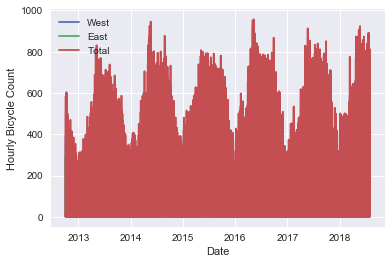

In [39]:
%matplotlib inline
import seaborn; seaborn.set()
import matplotlib.pyplot as plt

data.plot()
plt.ylabel('Hourly Bicycle Count');

在图中显示大约25 000 小时的样本数据对我们来说实在太多了，因此可以通过重新取样将数据转换成更大的颗粒度，比如按周累计（如图3-12 所示）：

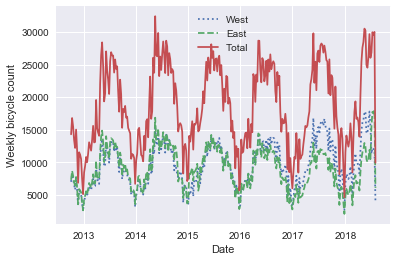

In [40]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count');

这就显示出一些季节性的特征了。正如你所想，夏天骑自行车的人比冬天多，而且某个季节中每一周的自行车数量也在变化（可能与天气有关，详情请参见5.6 节）。

另一种对数据进行累计的简便方法是用pd.rolling_mean()4 函数求移动平均值。下面将计算数据的30 日移动均值，并让图形在窗口居中显示（center=True）（如图3-13 所示）：

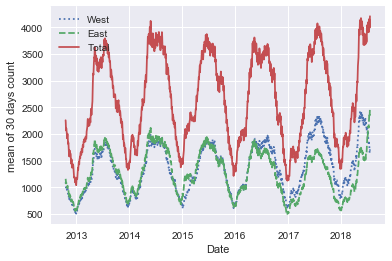

In [41]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).mean().plot(style=[':', '--', '-'])
plt.ylabel('mean of 30 days count');

由于窗口太小，现在的图形还不太平滑。我们可以用另一个移动均值的方法获得更平滑的图形，例如高斯分布时间窗口。下面的代码（可视化后如图3-14 所示）将设置窗口的宽度（选择50 天）和窗口内高斯平滑的宽度（选择10 天）：

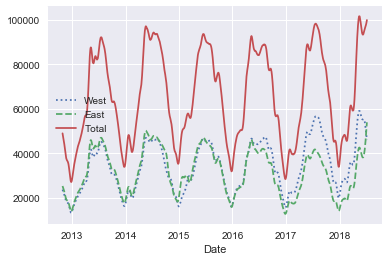

In [42]:
daily.rolling(50, center=True,
win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

#### 3.12.7.2. 深入挖掘数据
虽然我们已经从图3-14 的平滑数据图观察到了数据的总体趋势，但是它们还隐藏了一些有趣的特征。例如，我们可能希望观察单日内的小时均值流量，这可以通过GroupBy（详情请参见3.9 节）操作来解决（如图3-15 所示）：

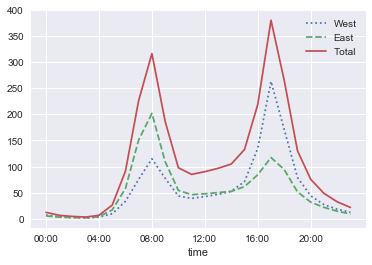

In [43]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

小时均值流量呈现出十分明显的双峰分布特征，早间峰值在上午8 点，晚间峰值在下午5 点。这充分反映了过桥上下班往返自行车流量的特征。进一步分析会发现，桥西的高峰在早上（因为人们每天会到西雅图的市中心上班），而桥东的高峰在下午（下班再从市中心离开）。

我们可能还会对周内每天的变化产生兴趣，这时依然可以通过一个简单的groupby 来实现（如图3-16 所示）：

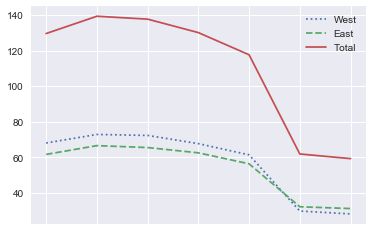

In [44]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

工作日与周末的自行车流量差十分显著，周一到周五通过的自行车差不多是周六、周日的两倍。

看到这个特征之后，让我们用一个复合groupby 来观察一周内工作日与双休日每小时的数据。用一个标签表示双休日和工作日的不同小时：

In [45]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

现在用一些Matplotlib 工具（详情请参见4.10 节）画出两张图（如图3-17 所示）：

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


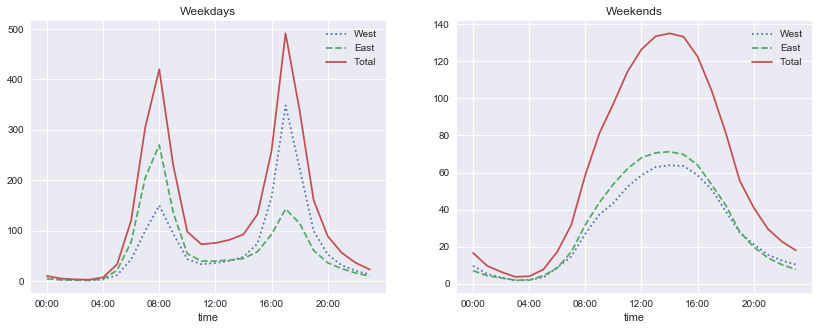

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
xticks=hourly_ticks, style=[':', '--', '-'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
xticks=hourly_ticks, style=[':', '--', '-']);

结果很有意思，我们会发现工作日的自行车流量呈双峰通勤模式（bimodal commute pattern），而到了周末就变成了单峰娱乐模式（unimodal recreational pattern）。假如继续挖掘数据应该还会发现更多有趣的信息，比如研究天气、温度、一年中的不同时间以及其他因素对人们通勤模式的影响。关于更深入的分析内容，请参考我的博文[“Is Seattle Really Seeing an Uptick In
Cycling?”](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)，里面用数据的子集作了一些分析。我们将在5.6 节继续使用这个数据集。